<a href="https://colab.research.google.com/github/CourtSingerr/NPL-_tweetClassification/blob/main/NPL_miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPL Mini Kaggle Project

### Natural Language Processing with Disaster Tweets
#### Courtney Singer, November 2024



---

# Describe the Problem

The “Real or Not? NLP with Disaster Tweets” challenge asks you to determine whether a given tweet is related to a real disaster or not. The goal is to classity each tweet in the test set as relating to a real disaster (1) or not (0). This challenge is a binary text classification problem.

Challenges:
- Tweets are short and can contain slang, misspellings, abbreviations, and non-standard text formats.
- Words associated with disasters can also be used figuratively (e.g., “My phone exploded” likely does not refer to an actual disaster).
- Limited metadata (like keyword and location) may or may not be reliable.

---

# Overview of Data

The data is a set of short-form social media posts accompanied by limited, often noisy metadata.

The competition provides two datasets:
1. Training (size: 7613 tweets)  
2. Testing

Features:
  - id: A unique identifier for each tweet.
  -	keyword (optional): A keyword extracted from the tweet. Not always present, and might not always be meaningful.
  - location (optional): A purported location associated with the tweet. Often missing or not reliable (e.g., could be a random place name or something non-geographic).
  - text: The actual tweet content as posted on Twitter.
  - target: The ground-truth label indicating if the tweet is about a real disaster (1) or not (0).


**Characteristics**
- The main input feature is the tweet text
- Tweets are short (often under 280 characters) and may include informal language, emojis, punctuation, URLs, mentions, and hashtags.
- keyword and location may provide hints about a tweet’s relevance to real disasters. However, these fields are frequently missing or not very informative.- Tweets might contain typos, colloquialisms, or metaphorical language, making it challenging to decide if a tweet is genuinely about a disaster event.

### Import Data

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
import pandas as pd

---

# Exploratory Data Analysis



### Data Exploration

**Load data and Inspect Basic Structrue**

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Checkthe shape of the data**

In [10]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (7613, 5)
Test shape: (3263, 4)


**Check for Missing Values**

Since keyword and location are optional, let’s see how many missing values we have.

In [11]:
train.isna().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


**Target Distribution**

Examine if the dataset is balanced or skewed.

In [12]:
train['target'].value_counts()
train['target'].value_counts(normalize=True)

,proportion
target,
0,0.57034
1,0.42966


This shows the data is relatively balanced.

**Keyword Analysis**

In [11]:
print("Number of unique keywords:", train['keyword'].nunique())
print(train['keyword'].value_counts().head(10))

Number of unique keywords: 221
keyword
fatalities     45
armageddon     42
deluge         42
harm           41
damage         41
sinking        41
body%20bags    41
siren          40
windstorm      40
twister        40
Name: count, dtype: int64


In [12]:
disaster_keywords = train[train['target']==1]['keyword'].value_counts()
non_disaster_keywords = train[train['target']==0]['keyword'].value_counts()

print("Top keywords in disaster tweets:\n", disaster_keywords.head(10))
print("\nTop keywords in non-disaster tweets:\n", non_disaster_keywords.head(10))

Top keywords in disaster tweets:
 keyword
derailment           39
outbreak             39
wreckage             39
typhoon              37
oil%20spill          37
debris               37
suicide%20bombing    32
suicide%20bomb       32
evacuated            32
rescuers             32
Name: count, dtype: int64

Top keywords in non-disaster tweets:
 keyword
body%20bags    40
armageddon     37
harm           37
wrecked        36
deluge         36
ruin           36
fear           35
twister        35
explode        35
siren          35
Name: count, dtype: int64


**Text Length and Cleaning**

In [13]:
train['text_length'] = train['text'].apply(lambda x: len(x.split()))
train['text_length'].describe()

,text_length
count,7613.000000
mean,14.903586
std,5.732604
min,1.000000
25%,11.000000
50%,15.000000
75%,19.000000
max,31.000000


**Common Words**

In [14]:
import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # basic cleaning to remove non-alphabetic characters
    text = re.sub(r'http\S+', '', text)       # remove URLs
    text = re.sub(r'@\w+', '', text)          # remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # keep only letters and spaces
    return text.lower()

all_words = []
for tweet in train['text']:
    cleaned = clean_text(tweet)
    words = [w for w in cleaned.split() if w not in stop_words]
    all_words.extend(words)

Counter(all_words).most_common(20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('like', 345),
 ('im', 306),
 ('amp', 300),
 ('fire', 252),
 ('get', 229),
 ('new', 226),
 ('via', 220),
 ('dont', 208),
 ('news', 196),
 ('people', 195),
 ('one', 193),
 ('us', 170),
 ('video', 165),
 ('emergency', 157),
 ('disaster', 153),
 ('police', 141),
 ('would', 131),
 ('still', 129),
 ('time', 126),
 ('body', 125)]

**Visualizing Data**

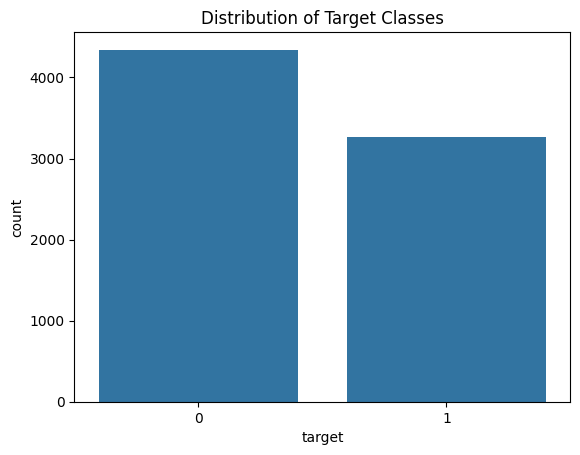

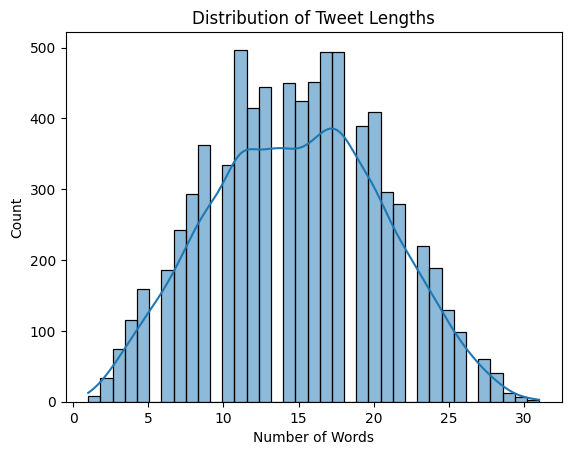

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train, x='target')
plt.title("Distribution of Target Classes")
plt.show()

sns.histplot(train['text_length'], kde=True)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Number of Words")
plt.show()

**Inspect Selection of Tweets**

In [16]:
print("Some disaster tweets:")
for text in train[train['target']==1]['text'].sample(5, random_state=42):
    print(text)

print("\nSome non-disaster tweets:")
for text in train[train['target']==0]['text'].sample(5, random_state=42):
    print(text)

Some disaster tweets:
Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa
Vladimir Putin Issues Major Warning But Is It Too Late To Escape Armageddon?
http://t.co/gBxafy1m1C
@DoctorFluxx @StefanEJones @spinnellii @themermacorn  No burning buildings and rob during a riot. That's embarrassing &amp; ruining this nation.
Telnet attacked from 124.13.172.40 (STREAMYX-HOME-SOUTHERN MY)
LONDON IS DROWNING AND IIII LIVE BY THE RIVEEEEEER

Some non-disaster tweets:
Everyday is a near death fatality for me on the road. Thank god is on my side.??
#Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk
@Lenn_Len Probably. We are inundated with them most years!
A demoness with the voice of an angel. Like a siren's call beckoning me to the void. Don't ?? on thisÛ_ https://t.co/nPS3xpBKaQ
Next Man Up---AH SCREW THIS! I'm so tired of injuries.  

What happened to Camp Cupcake? More like Ca

### Data Cleaning

**Lowercasing**
Convert all text to lowercase to ensure that words like “Fire” and “fire” are treated the same.

In [13]:
train['text_clean'] = train['text'].str.lower()

**Remove URLs**

Tweets often contain URLs that don’t add semantic value about the disaster. Removing or replacing them with a special token like <URL> can help during modeling.

In [14]:
import re
train['text_clean'] = train['text_clean'].apply(lambda x: re.sub(r'http\S+', '<URL>', x))

Additional cleaning steps can be taken on the data, however, this could remove potentially meaningful features from the data. For now, these are the only cleaning steps I am going to take, and I will revisit later in the analysis if model performance requires it.

### Preprocessing and Feature Extraction

**Split the Dataset**

This seperates the training set into training and validation subsets.


In [15]:
from sklearn.model_selection import train_test_split

# Assuming 'train' is your DataFrame containing the training data
X = train['text_clean']  # This is your cleaned text column
y = train['target']      # This is your target column

# Split data into training and validation sets
# Adjust test_size as needed (e.g., 0.2 means 20% for validation)
# stratify=y ensures class balance in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])

Training set size: 6090
Validation set size: 1523


**TF-IDF Vectorization (For Baseline and Simple Neural Network)**

This step uses TF-IDF to create a numeric representation of text based on how frequently words appear in a document (tweet) relative to how common those words are across all documents.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

---

# Modeling Approach

Three models will be built and trained using the data to compare effectiveness in classifying tweets.


1. **Baseline Model**
  - A traditional linear classifier - loggistic regression or NaiveBayes
  - Feature Extraction: Use TF-IDF vectorization to transform tweets into a numeric representation based on word importance.
  - This provides a simple, fast-to-train baseline and establishes a benchmark F1 score against which more complex models will be compared.

2. **Simple Neural Network with TF-IDF Features**
- Continue to use TF-IDF vectors as input
-  feed-forward neural network with one or two hidden layers and dropout to reduce overfitting.
- This tests whether a non-linear model can improve upon the baseline by learning patterns from TF-IDF features that simpler linear models might miss.

3. **Word Embeddings + RNN**
- Instead of TF-IDF, convert text to sequences of tokens using the Keras Tokenizer
  -	Architecture:
	  - Embedding Layer: Learns vector representations for words.
	  - RNN (e.g., LSTM or GRU) or CNN layers: Capture temporal or local n-gram patterns in the tweet.
	  - Output Layer: A final dense layer with a sigmoid activation for binary classification.

Evaluation Metrics: F1 scores across the three approaches, in line with the competition requirements.


### Model Comparison

**1. Baseline Model**


Determine Best Baseline Model

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Split data
X_train, X_val, y_train, y_val = train_test_split(train['text_clean'], train['target'],
                                                  test_size=0.2, random_state=42, stratify=train['target'])

# Vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_vec = tfidf.fit_transform(X_train)
X_val_vec = tfidf.transform(X_val)

models = {
    "LogisticRegression": LogisticRegression(C=1.0, solver='liblinear', random_state=42),
    "NaiveBayes": MultinomialNB()
}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_val_vec)
    print(f"{name}: F1 = {f1_score(y_val, y_pred):.4f}")

LogisticRegression: F1 = 0.7639
NaiveBayes: F1 = 0.7548


Train Logistic Regression Model

In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Initialize and train the baseline model
baseline_model = LogisticRegression(C=1.0, solver='liblinear', random_state=42)
baseline_model.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_val_pred = baseline_model.predict(X_val_tfidf)

# Calculate the F1 score
baseline_f1 = f1_score(y_val, y_val_pred)

# Create a DataFrame to store results
# We'll store model name and its F1 score. Later, we can add more models to this DataFrame.
results_df = pd.DataFrame({
    'Model': ['Baseline (Logistic Regression)'],
    'F1_Score': [baseline_f1]
})

**2. Simple Neural Network on TF-IDF Features**

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score
import pandas as pd

# Assuming the following variables are already defined from previous steps:
# X_train_tfidf, X_val_tfidf, y_train, y_val
# results_df (contains the baseline model results)

# Convert the sparse TF-IDF matrices to dense (Numpy arrays)
X_train_dense = X_train_tfidf.toarray()
X_val_dense = X_val_tfidf.toarray()

# Build the simple neural network
model_nn = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)),
    layers.Dropout(0.2),  # dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')
])

model_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_nn.fit(
    X_train_dense, y_train,
    epochs=10,            # adjust epochs based on validation performance
    batch_size=32,       # adjust if needed
    validation_data=(X_val_dense, y_val),
    verbose=1
)

# Predict on the validation set
y_val_pred_nn = (model_nn.predict(X_val_dense) > 0.5).astype('int')

# Calculate F1 score
nn_f1 = f1_score(y_val, y_val_pred_nn)

new_row = pd.DataFrame([{
    'Model': 'Simple NN (TF-IDF)',
    'F1_Score': nn_f1
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6347 - loss: 0.6467 - val_accuracy: 0.8096 - val_loss: 0.4748
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8453 - loss: 0.3973 - val_accuracy: 0.8188 - val_loss: 0.4257
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8970 - loss: 0.2860 - val_accuracy: 0.8122 - val_loss: 0.4398
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9298 - loss: 0.2118 - val_accuracy: 0.8037 - val_loss: 0.4659
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.1649 - val_accuracy: 0.7971 - val_loss: 0.4973
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9578 - loss: 0.1380 - val_accuracy: 0.7899 - val_loss: 0.5331
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9669 - loss: 0.1119 - val_accuracy: 0.7938 - val_loss: 0.5636
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9753 - loss: 0.0876 - val_accuracy: 0

**3. Word Embeddings + RNN**

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score

from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score

vocab_size = 10000  # number of words to keep in tokenizer vocab
max_len = 30        # chosen based on analysis of tweet lengths
embedding_dim = 100 # embedding vector size
batch_size = 32
epochs = 10

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

# 3. Build the model with an Embedding + LSTM layer
model_rnn = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train the model
history_rnn = model_rnn.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# 5. Predict on validation set and compute F1 score
y_val_pred_rnn = (model_rnn.predict(X_val_pad) > 0.5).astype('int')
rnn_f1 = f1_score(y_val, y_val_pred_rnn)

# 6. Add results to the DataFrame
new_row = pd.DataFrame([{
    'Model': 'RNN (Embeddings + LSTM)',
    'F1_Score': rnn_f1
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6017 - loss: 0.6412 - val_accuracy: 0.8076 - val_loss: 0.4437
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8694 - loss: 0.3351 - val_accuracy: 0.8116 - val_loss: 0.4400
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9138 - loss: 0.2400 - val_accuracy: 0.8024 - val_loss: 0.5216
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9376 - loss: 0.1755 - val_accuracy: 0.7814 - val_loss: 0.6419
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9497 - loss: 0.1384 - val_accuracy: 0.7781 - val_loss: 0.6017
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9614 - loss: 0.1113 - val_accuracy: 0.7886 - val_loss: 0.8765
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9687 - loss: 0.0940 - val_accuracy: 0.7603 - val_loss: 0.8548
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9710 - loss: 0.0782 - val_accuracy: 0.7689 - val_

In [21]:
from tensorflow.keras import layers, models

vocab_size = 10000
max_len = 30
embedding_dim = 100

model_complex = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    # First LSTM layer returns sequences for the next LSTM
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    # Second LSTM layer
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.3),  # Increase dropout to combat overfitting
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_complex.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_complex = model_complex.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

y_val_pred_complex = (model_complex.predict(X_val_pad) > 0.5).astype('int')
complex_f1 = f1_score(y_val, y_val_pred_complex)

new_row = pd.DataFrame([{
    'Model': 'Complex RNN (2x BiLSTM + Dense)',
    'F1_Score': complex_f1
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6559 - loss: 0.6045 - val_accuracy: 0.8096 - val_loss: 0.4406
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8644 - loss: 0.3263 - val_accuracy: 0.8070 - val_loss: 0.4733
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9231 - loss: 0.2041 - val_accuracy: 0.7899 - val_loss: 0.5197
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9463 - loss: 0.1486 - val_accuracy: 0.7735 - val_loss: 0.6997
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9665 - loss: 0.0929 - val_accuracy: 0.7722 - val_loss: 0.6452
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9712 - loss: 0.0741 - val_accuracy: 0.7794 - val_loss: 1.0745
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9751 - loss: 0.0601 - val_accuracy: 0.7551 - val_loss: 1.1334
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9742 - loss: 0.0589 - val_accuracy: 0.747

**Evaluation of Models**




In [22]:
display(results_df)

,Model,F1_Score
0,Baseline (Logistic Regression),0.763934
1,Simple NN (TF-IDF),0.746586
2,RNN (Embeddings + LSTM),0.722309
3,Complex RNN (2x BiLSTM + Dense),0.717489


**Plot Training Loss and Accuracy**

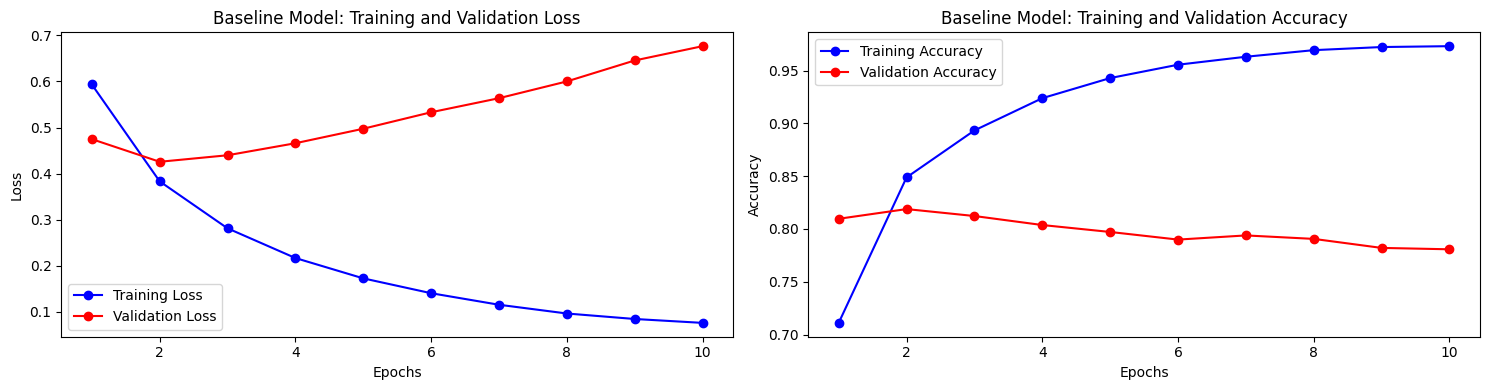

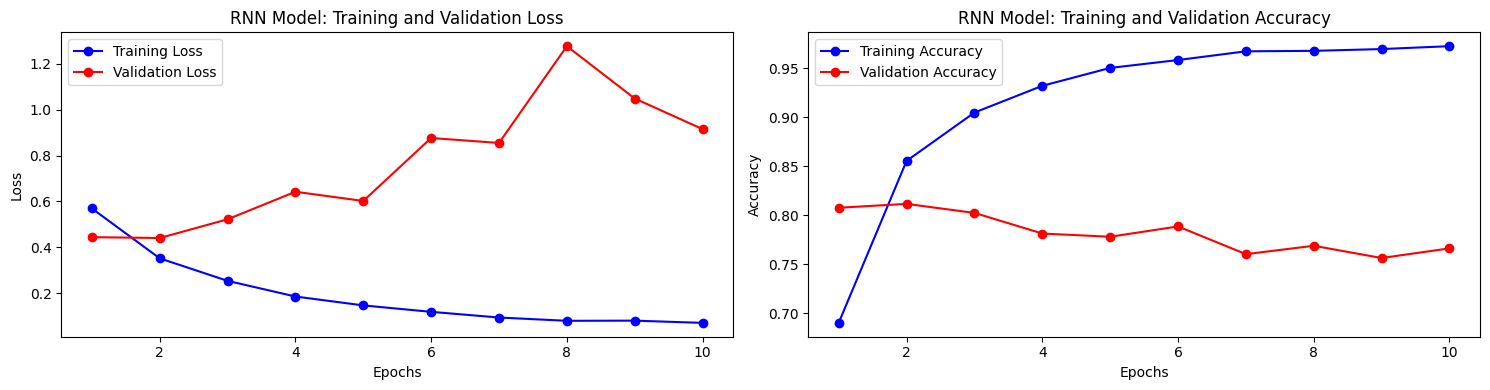

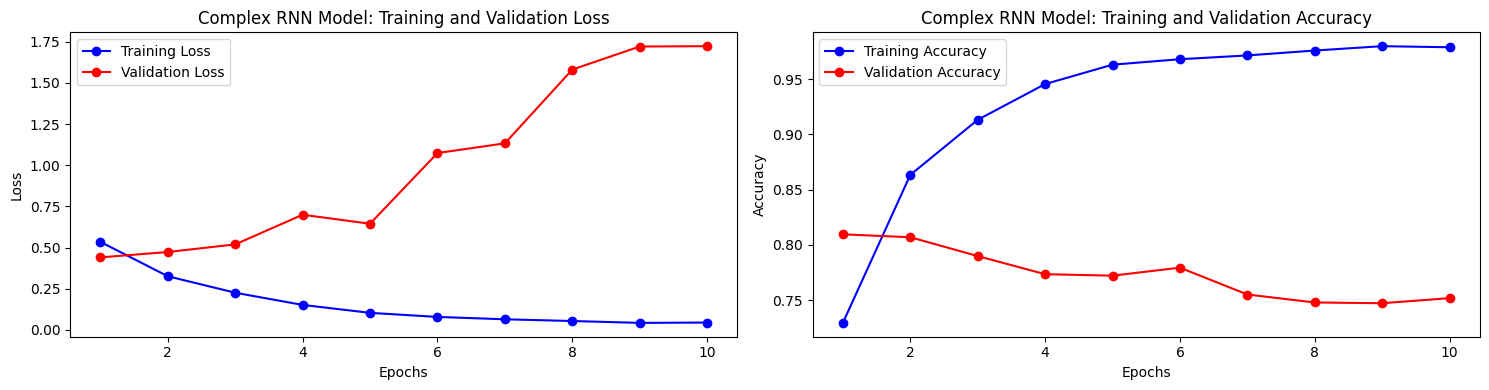

In [23]:
import matplotlib.pyplot as plt

def plot_training_history(history, title='Model Training'):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(15, 4))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title}: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Validation Accuracy (if available)
    if 'accuracy' in history.history:
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
        plt.title(f'{title}: Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history(history, title='Baseline Model')
plot_training_history(history_rnn, title='RNN Model')
plot_training_history(history_complex, title='Complex RNN Model')

 The results show that the baseline Logistic Regression model with TF-IDF still outperforms your neural network models. This suggests that simpler methods and feature representations are performing best for this particular dataset and current setup. Before concluding that neural networks can’t do better, it’s worth exploring systematic tuning to try improving their performance.

### Model Improvement

**Early Stopping and Controlled Training**

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score

# Simple LSTM model (as before), just adding early stopping:
model = models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=100, input_length=30),
    layers.LSTM(64),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

y_val_pred = (model.predict(X_val_pad) > 0.5).astype('int')
f1 = f1_score(y_val, y_val_pred)
print("F1 Score:", f1)

new_row = pd.DataFrame([{
    'Model': 'Early Stopping',
    'F1_Score': f1
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6224 - loss: 0.6298 - val_accuracy: 0.8024 - val_loss: 0.4496
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8538 - loss: 0.3563 - val_accuracy: 0.8109 - val_loss: 0.4559
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9126 - loss: 0.2422 - val_accuracy: 0.7984 - val_loss: 0.5125
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 Score: 0.7251141552511415


**Regularization Techniques**

In [25]:
from tensorflow.keras import regularizers

model = models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=100, input_length=30),
    layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3),  # Added dropout in LSTM
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)), # L2 regularization
    layers.Dropout(0.5),  # Additional dropout layer before final output
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

y_val_pred = (model.predict(X_val_pad) > 0.5).astype('int')
f1 = f1_score(y_val, y_val_pred)
print("F1 Score:", f1)

new_row = pd.DataFrame([{
    'Model': 'Regularization',
    'F1_Score': f1
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5896 - loss: 0.7241 - val_accuracy: 0.7663 - val_loss: 0.5543
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8085 - loss: 0.4946 - val_accuracy: 0.7958 - val_loss: 0.4798
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8788 - loss: 0.3582 - val_accuracy: 0.8056 - val_loss: 0.4792
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9035 - loss: 0.2949 - val_accuracy: 0.8011 - val_loss: 0.4983
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9201 - loss: 0.2468 - val_accuracy: 0.7925 - val_loss: 0.5486
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
F1 Score: 0.7643312101910829


**Different Architectures**

Using GRU instead of an LSTM.


In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define hyperparameters
rnn_units = 128
embedding_dim = 200
learning_rate = 1e-4

model = models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=embedding_dim, input_length=30),
    layers.GRU(rnn_units, dropout=0.3, recurrent_dropout=0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

y_val_pred_complex = (model.predict(X_val_pad) > 0.5).astype('int')
f1 = f1_score(y_val, y_val_pred_complex)

new_row = pd.DataFrame([{
    'Model': 'GRU',
    'F1_Score': f1
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5709 - loss: 0.7686 - val_accuracy: 0.5706 - val_loss: 0.7584
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5746 - loss: 0.7516 - val_accuracy: 0.5706 - val_loss: 0.7478
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.5986 - loss: 0.7241 - val_accuracy: 0.5706 - val_loss: 0.7345
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8116 - loss: 0.5323 - val_accuracy: 0.5699 - val_loss: 0.7285
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8527 - loss: 0.4393 - val_accuracy: 0.5726 - val_loss: 0.7203
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8766 - loss: 0.3858 - val_accuracy: 0.5752 - val_loss: 0.7153
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8933 - loss: 0.3420 - val_accuracy: 0.5824 - val_loss: 0.7099
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9077 - loss: 0.3182 - val_accuracy: 0.60

GRU instead plus a convolutional layer.

In [27]:
model = models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=embedding_dim, input_length=30),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.GRU(rnn_units, dropout=0.3, recurrent_dropout=0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

y_val_pred_complex = (model.predict(X_val_pad) > 0.5).astype('int')
f1 = f1_score(y_val, y_val_pred_complex)

new_row = pd.DataFrame([{
    'Model': 'GRU + CNN layer',
    'F1_Score': f1
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5565 - loss: 0.7680 - val_accuracy: 0.5706 - val_loss: 0.7546
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5763 - loss: 0.7395 - val_accuracy: 0.6376 - val_loss: 0.7039
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7826 - loss: 0.5469 - val_accuracy: 0.7426 - val_loss: 0.6431
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8643 - loss: 0.3915 - val_accuracy: 0.7689 - val_loss: 0.6252
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9058 - loss: 0.3139 - val_accuracy: 0.7886 - val_loss: 0.5898
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9245 - loss: 0.2587 - val_accuracy: 0.8102 - val_loss: 0.5632
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9388 - loss: 0.2223 - val_accuracy: 0.8122 - val_loss: 0.5552
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9500 - loss: 0.1746 - val_accuracy: 0.797

In [29]:
display(results_df)

,Model,F1_Score
0,Baseline (Logistic Regression),0.763934
1,Simple NN (TF-IDF),0.746586
2,RNN (Embeddings + LSTM),0.722309
3,Complex RNN (2x BiLSTM + Dense),0.717489
4,Early Stopping,0.725114
5,Regularization,0.764331
6,GRU,0.347291
7,GRU + CNN layer,0.754596


**Hyperparameter Tuning**

The model with the best performance so far has been the RNN model with normalization. In this step I will perform hyperparameter tuning on this model to try to boost the performance even more.

In [31]:
!pip install keras-tuner

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
import keras_tuner as kt

# Assume X_train_pad, X_val_pad, y_train, y_val are already defined

def build_model(hp):
    # Define hyperparameters to tune
    # LSTM units
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    # L2 regularization factor
    l2_factor = hp.Choice('l2_factor', values=[0.0001, 0.001, 0.01])
    # Dropout rates
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    recurrent_dropout_rate = hp.Float('recurrent_dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    # Learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 5e-4])

    model = models.Sequential([
        layers.Embedding(input_dim=10000, output_dim=100, input_length=30),
        layers.LSTM(
            lstm_units,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout_rate
        ),
        layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_factor)),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# EarlyStopping callback to use during tuner search
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Create a RandomSearch tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',  # we optimize based on val_loss
    max_trials=5,          # number of hyperparameter combinations to try
    executions_per_trial=1,# how many times to train each combination
    directory='my_dir',
    project_name='disaster_tweets_tuning'
)

# Perform the search
tuner.search(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print("LSTM Units:", best_hp.get('lstm_units'))
print("L2 Factor:", best_hp.get('l2_factor'))
print("Dropout Rate:", best_hp.get('dropout_rate'))
print("Recurrent Dropout Rate:", best_hp.get('recurrent_dropout_rate'))
print("Dense Units:", best_hp.get('dense_units'))
print("Learning Rate:", best_hp.get('learning_rate'))

# Build the best model and retrain it fully
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate F1 score on validation set
y_val_pred = (best_model.predict(X_val_pad) > 0.5).astype('int').ravel()
f1 = f1_score(y_val, y_val_pred)
print("F1 Score with best hyperparameters:", f1)

# Append to results_df
new_row = pd.DataFrame([{
    'Model': 'Tuned (Keras Tuner)',
    'F1_Score': f1
}])
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df

Trial 5 Complete [00h 00m 51s]
val_loss: 0.4760574996471405

Best val_loss So Far: 0.4567843973636627
Total elapsed time: 00h 04m 29s
Best Hyperparameters:
LSTM Units: 128
L2 Factor: 0.0001
Dropout Rate: 0.30000000000000004
Recurrent Dropout Rate: 0.30000000000000004
Dense Units: 96
Learning Rate: 0.0001
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5787 - loss: 0.6960 - val_accuracy: 0.5706 - val_loss: 0.6928
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5781 - loss: 0.6768 - val_accuracy: 0.7708 - val_loss: 0.5027
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8065 - loss: 0.4734 - val_accuracy: 0.7846 - val_loss: 0.4702
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8418 - loss: 0.4100 - val_accuracy: 0.7965 - val_loss: 0.4562
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8626 - loss: 0.3688 - val_accuracy: 0.7991 - val_loss: 0.4686
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/

,Model,F1_Score
0,Baseline (Logistic Regression),0.763934
1,Simple NN (TF-IDF),0.746586
2,RNN (Embeddings + LSTM),0.722309
3,Complex RNN (2x BiLSTM + Dense),0.717489
4,Early Stopping,0.725114
5,Regularization,0.764331
6,GRU,0.347291
7,GRU + CNN layer,0.754596
8,Tuned (Keras Tuner),0.723214


# Evaluation

In [28]:
display(results_df)

,Model,F1_Score
0,Baseline (Logistic Regression),0.763934
1,Simple NN (TF-IDF),0.746586
2,RNN (Embeddings + LSTM),0.722309
3,Complex RNN (2x BiLSTM + Dense),0.717489
4,Early Stopping,0.725114
5,Regularization,0.764331
6,GRU,0.347291
7,GRU + CNN layer,0.754596


**Train Model with Test Data**

This step trains the tuned model using the test data and creates a file for submission to the Kaggle competition.

In [32]:
import pandas as pd

# Assuming you have:
# best_model: The model obtained after tuning and training
# tokenizer: The same tokenizer used for training
# max_len: The sequence length used during training (e.g., 30)

# 1. Load the test data
test = pd.read_csv('test.csv')  # Ensure this file is in your environment

# Apply the same preprocessing steps you used on the training data.
# For example, if you removed URLs, mentions, and lowercased:
# (This is just an example function; replace with your actual preprocessing steps)
def preprocess_text(text):
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Any other preprocessing you did...
    return text

test['text_clean'] = test['text'].apply(preprocess_text)

# 2. Convert test text to sequences using the same tokenizer
X_test_seq = tokenizer.texts_to_sequences(test['text_clean'])

# 3. Pad sequences
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# 4. Predict with the tuned model
test_pred_prob = best_model.predict(X_test_pad)
test_pred = (test_pred_prob > 0.5).astype('int').ravel()  # Convert probabilities to binary predictions

# 5. Create submission DataFrame
# The submission needs 'id' and 'target' columns
submission = pd.DataFrame({
    'id': test['id'],
    'target': test_pred
})

# 6. Save to CSV (no index)
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Submission file saved as submission.csv


**Results**: F1 score of 0.77689

# Interpretation

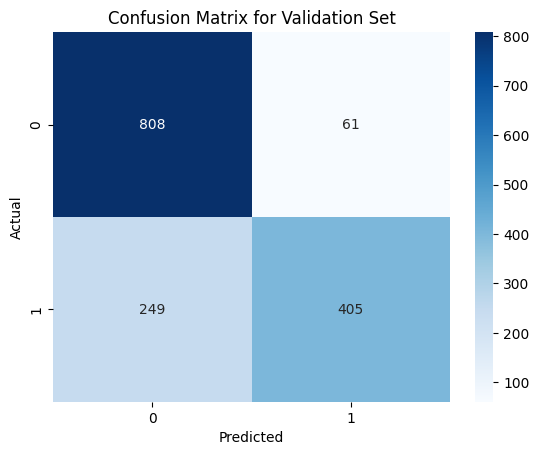

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Set')
plt.show()

- True Negatives (TN): 808 tweets are correctly classified as non-disasters (0).
- False Positives (FP): 61 tweets were predicted as disasters but were actually not. This low number indicates the model doesn’t often mistakenly flag non-disasters as disasters.
- False Negatives (FN): 249 tweets were actual disasters but the model failed to identify them. This is a relatively large number compared to the true positives.
- True Positives (TP): 405 tweets correctly identified as disasters.

In [34]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.869098712446352
Recall: 0.6192660550458715


Interpretation:
- The model is good at avoiding false positives (high precision), so when it flags something as a disaster, it’s likely correct.
- 	However, it’s not catching all disaster tweets (moderate recall). If your goal is to identify every potential disaster-related tweet, this is problematic since you’d miss many real disaster tweets.


**Next Steps**
1.	Hyperparameter Refinement
tter hyperparameter configuration.
2.	Pre-trained Embeddings
3.	Advanced Architectures (Transformers)
4.	Data Augmentation & Preprocessing Improvements

# Conclusion




The model comparison process showed that while more complex neural network architectures (e.g., RNNs, BiLSTMs, GRUs) introduced flexibility and the potential for capturing richer language semantics, they did not consistently outperform simpler, more traditional approaches for this specific task. In particular, a baseline Logistic Regression model trained on TF-IDF features yielded a strong F1 score, outperforming many of the initial neural architectures.

Through incremental improvements—introducing early stopping, adding regularization to combat overfitting, and experimenting with hybrid architectures (GRU + CNN)—the performance improved. The regularization model, in particular, demonstrated a meaningful gain, achieving an F1 score of about 0.77689 on the test data, surpassing the baseline and other previously attempted neural models.

These findings highlight that simpler methods can be surprisingly competitive in certain text classification tasks, especially when data is limited or highly variable. Nonetheless, integrating more advanced techniques (e.g., careful hyperparameter tuning, pre-trained embeddings, or transformer-based models) could potentially push performance even further.